In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer

# Load your dataset
df = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
# df = df[~df['sii'].isin([2, 3])]

# Drop rows with missing values in 'sii'
# df = df.dropna(subset=['sii'])

# Target columns to predict
target_columns = [
    'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 
    'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 
    'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 
    'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 
    'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 
    # 'PCIAT-PCIAT_Total'
]

# Features (X): Drop target columns and irrelevant columns
irrelevant_columns = [
    'id', 'Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season',
    'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season',
    'PCIAT-PCIAT_Total',
    'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season', 'sii', 'PCIAT-Season'
]
X = df.drop(columns=target_columns + irrelevant_columns)

# Convert all columns to numeric and handle invalid values
X = X.apply(pd.to_numeric, errors='coerce')

# Initialize the KNN Imputer
knn_imputer = KNNImputer(n_neighbors=10)

# Impute missing values and convert back to DataFrame
X_imputed = pd.DataFrame(knn_imputer.fit_transform(X), columns=X.columns)

# Create a DataFrame to store predictions
predictions_df = pd.DataFrame()

# Loop through each target column for prediction
for target in target_columns:
    print(f"Training model for target: {target}")
    
    # Define target variable
    y = df[target]
    
    # Drop rows with missing values in target column
    df_combined = pd.concat([X_imputed, y], axis=1)
    df_combined = df_combined.dropna(subset=[target])
    
    # Ensure `y` is numeric after dropping NaNs
    y = pd.to_numeric(df_combined[target], errors='coerce')
    
    # Align X and y after dropping NaNs
    X_valid = df_combined.drop(columns=[target])
    y_valid = df_combined[target]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_valid, y_valid, test_size=0.0001, random_state=42)
    
  # XGBoost parameters intentionally set to cause overfitting
    overfitting_params = {
        'max_depth': 8,              # Very high depth for overfitting
        'min_child_weight': 1,        # Low value to allow splitting even for small datasets
        'gamma': 0,                   # No regularization on splits
        'learning_rate': 0.5,         # High learning rate
        'n_estimators': 500,          # Large number of trees
        'subsample': 1,               # Use all data for each tree
        'colsample_bytree': 1,        # Use all features for each tree
        'reg_alpha': 0,               # No L1 regularization
        'reg_lambda': 0               # No L2 regularization
}

    # Create and train the XGBoost model
    model = xgb.XGBRegressor(**overfitting_params)
    # model = xgb.XGBRegressor()
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Add predictions to the DataFrame
    predictions_df[target] = pd.Series(y_pred, index=y_test.index)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error for {target}: {mse}")
    model.save_model(f'{target}_model.json')



Training model for target: PCIAT-PCIAT_01
Mean Squared Error for PCIAT-PCIAT_01: 11.35068965181691
Training model for target: PCIAT-PCIAT_02
Mean Squared Error for PCIAT-PCIAT_02: 16.330783846239402
Training model for target: PCIAT-PCIAT_03
Mean Squared Error for PCIAT-PCIAT_03: 2.482437688932123
Training model for target: PCIAT-PCIAT_04
Mean Squared Error for PCIAT-PCIAT_04: 0.49854545871221845
Training model for target: PCIAT-PCIAT_05
Mean Squared Error for PCIAT-PCIAT_05: 0.5655037819824429
Training model for target: PCIAT-PCIAT_06
Mean Squared Error for PCIAT-PCIAT_06: 0.37927060041056393
Training model for target: PCIAT-PCIAT_07
Mean Squared Error for PCIAT-PCIAT_07: 0.00031428789293702977
Training model for target: PCIAT-PCIAT_08
Mean Squared Error for PCIAT-PCIAT_08: 0.09199741222722935
Training model for target: PCIAT-PCIAT_09
Mean Squared Error for PCIAT-PCIAT_09: 4.789567413798977
Training model for target: PCIAT-PCIAT_10
Mean Squared Error for PCIAT-PCIAT_10: 6.0032713041110

In [59]:
import pandas as pd
import xgboost as xgb
from sklearn.impute import KNNImputer

# Load the test data
test_data = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/test.csv")

# Drop irrelevant columns
irrelevant_columns = [
    'id', 'Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season',
    'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season',
    # 'PCIAT-PCIAT_Total',
    'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season',
]
test_data = test_data.drop(columns=irrelevant_columns)

# Convert all columns to numeric and handle invalid values
test_data = test_data.apply(pd.to_numeric, errors='coerce')

# Initialize the KNN Imputer and impute missing values
knn_imputer = KNNImputer(n_neighbors=10)
test_data = pd.DataFrame(knn_imputer.fit_transform(test_data), columns=test_data.columns)

# Initialize the DataFrame to store predictions
predictions_df = pd.DataFrame()

# Loop through each target column for prediction
for target in target_columns:
    # Step 1: Load the saved XGBoost model
    model = xgb.XGBRegressor()
    model.load_model(f'{target}_model.json')
    
    # Step 2: Make predictions on the test data
    predictions = model.predict(test_data)
    
    # Step 3: Store predictions in the DataFrame
    predictions_df[target] = pd.Series(predictions, index=test_data.index)

# Step 4: Save the predictions to a CSV file
predictions_df.to_csv('predictions.csv', index=False)

print("Predictions saved to 'predictions.csv'")


Predictions saved to 'predictions.csv'


In [60]:
predict = pd.read_csv("/kaggle/working/predictions.csv")

In [61]:
predict

,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20
0,4.363702,2.173683,2.475706,0.545770,3.216290,0.855963,0.368890,2.870939,1.260622,-0.042152,4.083768,0.058873,2.438994,3.645068,0.653896,4.978211,3.890844,2.759895,0.984110,3.524473
1,0.043677,0.455091,0.379136,-0.413609,1.849829,1.045954,-0.056354,0.173972,1.431805,0.529046,0.242458,-0.048497,0.248369,-0.195067,-0.221618,3.062620,-0.235651,0.369933,0.901544,1.888578
2,4.222609,1.461328,0.823500,1.281944,1.878494,0.770513,-0.408209,3.136097,1.864896,0.919000,1.221255,-0.023018,0.153748,1.023754,2.067657,1.779263,2.770603,3.132904,0.661756,1.758764
3,3.615251,0.956308,3.186025,0.503009,5.141432,0.865258,0.098059,1.368399,1.851515,0.073795,2.029597,0.218021,2.326453,0.111328,0.615371,3.619333,2.090193,2.326437,1.415449,3.027791
4,3.387869,1.669982,2.204757,0.733848,3.124140,1.236317,2.092777,3.037550,2.161686,1.400438,3.406420,1.592100,1.009866,1.925657,1.352940,1.067651,1.757740,1.240714,1.607254,2.080102
5,2.289725,1.836715,4.186882,0.001867,2.090183,0.808539,0.715171,4.049944,1.976229,2.320003,1.453208,0.834279,2.461991,2.639836,1.362243,-0.133612,2.612433,1.850865,1.505474,1.451664
6,-0.348622,4.278506,1.802669,0.508960,1.579709,0.963717,-0.007703,1.162769,0.162822,2.560190,1.141376,0.329985,-0.203755,0.815740,1.025233,2.485669,1.100676,2.188491,2.067071,3.187754
7,2.713015,1.160078,-0.383418,0.667532,2.886077,0.801090,0.234649,0.135098,0.063756,1.403548,1.329463,0.326325,-0.437686,1.226318,2.313967,1.188141,0.731838,0.377538,1.803307,4.314742
8,3.798535,1.514560,2.682502,0.885762,4.061381,1.399937,2.075909,2.644401,1.438978,1.261363,3.192646,1.162218,0.702212,1.510939,2.884197,1.497399,2.376144,2.125807,1.768127,2.755269
9,3.080320,1.642173,2.204757,0.731086,3.124140,1.020032,2.097520,3.041247,1.343175,1.065440,3.407407,1.592100,1.009866,1.925657,1.315487,1.064329,1.757740,1.226179,1.607254,2.170836


In [62]:
# Assuming 'predictions' is the array or Series you obtained from the model predictions
predictions_df = pd.DataFrame(predict)

# Concatenate predictions with the test data
test_data_with_predictions = pd.concat([test_data, predictions_df], axis=1)

# Now 'test_data_with_predictions' contains the original test data along with the predictions


In [63]:
test_data_with_predictions.head(20)

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20
0,5.0,0.0,51.0,16.877316,46.00,50.80,25.4,71.3,82.8,114.3,5.0,7.0,34.0,0.0,0.0,16.16,1.6,16.74,1.6,0.0,0.0,7.00,0.0,6.00,0.0,6.00,1.0,2.000,2.66855,16.879200,932.498,1492.0000,8.255980,41.586200,13.817700,3.061430,9.21377,1.000,24.43490,8.895360,38.917700,19.541300,32.690900,1.04,2.372333,36.8,52.3,3.0,4.363702,2.173683,2.475706,0.545770,3.216290,0.855963,0.368890,2.870939,1.260622,-0.042152,4.083768,0.058873,2.438994,3.645068,0.653896,4.978211,3.890844,2.759895,0.984110,3.524473
1,9.0,0.0,62.5,14.035590,48.00,46.00,22.0,75.0,70.0,122.0,5.0,7.0,34.0,3.0,0.0,16.16,1.6,16.74,1.6,5.0,0.0,11.00,1.0,11.00,1.0,3.00,0.0,2.000,2.57949,14.037100,936.656,1498.6500,6.019930,42.029100,12.825400,1.211720,3.97085,1.000,21.03520,14.974000,39.449700,15.410700,27.055200,1.04,2.340000,46.0,64.0,0.0,0.043677,0.455091,0.379136,-0.413609,1.849829,1.045954,-0.056354,0.173972,1.431805,0.529046,0.242458,-0.048497,0.248369,-0.195067,-0.221618,3.062620,-0.235651,0.369933,0.901544,1.888578
2,10.0,1.0,71.0,16.648696,56.50,75.60,25.4,65.0,94.0,117.0,5.0,7.0,33.0,20.0,1.0,10.20,1.0,14.70,2.0,7.0,1.0,10.00,1.0,10.00,1.0,5.00,0.0,2.625,3.63636,19.284788,1111.248,1886.9125,16.681051,60.625612,14.432937,4.851858,21.79939,1.625,28.48675,15.457795,56.989275,25.985962,45.167825,1.04,2.170000,38.0,54.0,2.0,4.222609,1.461328,0.823500,1.281944,1.878494,0.770513,-0.408209,3.136097,1.864896,0.919000,1.221255,-0.023018,0.153748,1.023754,2.067657,1.779263,2.770603,3.132904,0.661756,1.758764
3,9.0,0.0,71.0,18.292347,56.00,81.60,25.4,60.0,97.0,117.0,6.0,9.0,37.0,18.0,1.0,16.16,1.6,16.74,1.6,5.0,0.0,7.00,0.0,7.00,0.0,7.00,1.0,3.000,3.84191,18.294300,1131.430,1923.4400,15.592500,62.775700,14.074000,4.220330,18.82430,2.000,30.40410,16.779000,58.933800,26.479800,45.996600,1.04,2.451000,31.0,45.0,0.0,3.615251,0.956308,3.186025,0.503009,5.141432,0.865258,0.098059,1.368399,1.851515,0.073795,2.029597,0.218021,2.326453,0.111328,0.615371,3.619333,2.090193,2.326437,1.415449,3.027791
4,18.0,1.0,62.5,19.361074,56.10,87.10,25.4,71.5,81.3,118.4,5.0,7.0,34.0,10.7,0.5,16.16,1.6,16.74,1.6,5.2,0.2,7.60,0.6,8.35,0.7,8.35,0.6,2.625,3.63636,19.284788,1111.248,1886.9125,16.681051,60.625613,14.432937,4.851857,21.79939,1.625,28.48675,15.457795,56.989275,25.985962,45.167825,1.04,2.372333,36.8,52.3,1.5,3.387869,1.669982,2.204757,0.733848,3.124140,1.236317,2.092777,3.037550,2.161686,1.400438,3.406420,1.592100,1.009866,1.925657,1.352940,1.067651,1.757740,1.240714,1.607254,2.080102
5,13.0,1.0,50.0,22.279952,59.50,112.20,25.4,60.0,73.0,102.0,5.0,7.0,34.0,12.0,0.0,16.50,2.0,17.90,2.0,6.0,0.0,10.00,1.0,11.00,1.0,8.00,0.0,2.000,4.33036,30.186500,1330.970,1996.4500,30.212400,84.028500,16.687700,13.498800,67.97150,2.000,32.91410,20.902000,79.698200,35.380400,63.126500,1.04,4.110000,40.0,56.0,0.0,2.289725,1.836715,4.186882,0.001867,2.090183,0.808539,0.715171,4.049944,1.976229,2.320003,1.453208,0.834279,2.461991,2.639836,1.362243,-0.133612,

In [64]:
# Import necessary libraries
import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load your dataset
df = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
df = df[~df['sii'].isin([2, 3])]

# Drop rows with missing values in 'sii'
df = df.dropna(subset=['sii'])

# Features (X): Drop target columns and irrelevant columns
irrelevant_columns = [
    'id', 'Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season',
    'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season',
    'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season', 'sii', 'PCIAT-Season',
    'PCIAT-PCIAT_Total'
    
]
X = df.drop(columns=irrelevant_columns)

# Convert all columns to numeric and handle invalid values
X = X.apply(pd.to_numeric, errors='coerce')

# Initialize the KNN Imputer
knn_imputer = KNNImputer(n_neighbors=10)

# Impute missing values and convert back to DataFrame
X_imputed = pd.DataFrame(knn_imputer.fit_transform(X), columns=X.columns)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, df["sii"], test_size=0.0001, random_state=42)

# Initialize the XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Train the model
model.fit(X_train, y_train)

# Assuming 'model' is your trained XGBoost model
model_features = model.get_booster().feature_names  # Get feature names used during training
# Ensure the test data has the same column order as the model features
test_data_with_predictions = test_data_with_predictions[model_features].reindex(columns=model_features)

# Make predictions on the test set
y_pred = model.predict(test_data_with_predictions)

# Optionally, you can check the feature importance
print("Feature importance:")
print(model.feature_importances_)

Feature importance:
[0.00694861 0.         0.00481723 0.00245931 0.00882293 0.01346458
 0.00442502 0.00597056 0.00367985 0.00555138 0.0069816  0.00462711
 0.00228365 0.00780242 0.01161567 0.01234009 0.00371576 0.00628255
 0.0008339  0.00354033 0.00426622 0.00385966 0.00799866 0.00524757
 0.0027368  0.00589943 0.00353688 0.00612936 0.00522248 0.00272165
 0.02186476 0.00666408 0.00410719 0.         0.008218   0.00302741
 0.0069615  0.00270287 0.00241245 0.00493246 0.00085415 0.00558444
 0.00805747 0.00614402 0.00529528 0.01299352 0.06121967 0.0779475
 0.01475222 0.14207718 0.01231882 0.01674219 0.01161367 0.0280473
 0.01471289 0.02956909 0.02470547 0.02363831 0.02306551 0.06448335
 0.01068829 0.08109391 0.03147373 0.01516862 0.03315673 0.01449813
 0.00045984 0.00496674]


In [65]:
y_pred

array([1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1])

In [66]:
sample = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv")
Submission1 = pd.DataFrame({
    'id': sample['id'],
    'sii': y_pred
})


In [67]:
# Import necessary libraries
import lightgbm as lgb
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import KNNImputer
import pandas as pd

# Load your dataset
df = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')

# Drop rows with missing values in 'sii'
df = df.dropna(subset=['sii'])

# Features (X): Drop target columns and irrelevant columns
irrelevant_columns = [
    'id', 'Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season',
    'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season',
    'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season', 'sii', 'PCIAT-Season',
    'PCIAT-PCIAT_Total'
]
X = df.drop(columns=irrelevant_columns)

# Convert all columns to numeric and handle invalid values
X = X.apply(pd.to_numeric, errors='coerce')

# Initialize the KNN Imputer
knn_imputer = KNNImputer(n_neighbors=10)

# Impute missing values and convert back to DataFrame
X_imputed = pd.DataFrame(knn_imputer.fit_transform(X), columns=X.columns)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, df["sii"], test_size=0.0001, random_state=42)

# Initialize the LightGBM model
model = lgb.LGBMClassifier()

# Train the model
model.fit(X_train, y_train)

# Assuming 'model' is your trained LightGBM model
model_features = model.booster_.feature_name()  # Get feature names used during training
# Ensure the test data has the same column order as the model features
test_data_with_predictions = test_data_with_predictions[model_features].reindex(columns=model_features)

# Make predictions on the test set
y_pred = model.predict(test_data_with_predictions)

# Optionally, you can check the feature importance
print("Feature importance:")
print(model.feature_importances_)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7585
[LightGBM] [Info] Number of data points in the train set: 2735, number of used features: 68
[LightGBM] [Info] Start training from score -0.540512
[LightGBM] [Info] Start training from score -1.320842
[LightGBM] [Info] Start training from score -1.978993
[LightGBM] [Info] Start training from score -4.387526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [68]:
y_pred

array([1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 1.])

In [69]:
sample = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv")
Submission2 = pd.DataFrame({
    'id': sample['id'],
    'sii': y_pred
})


In [70]:
!pip -q install /kaggle/input/pytorchtabnet/pytorch_tabnet-4.1.0-py3-none-any.whl

In [71]:
import numpy as np
import pandas as pd
import os
import re
import copy
import pickle
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline

import plotly.express as px

warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [72]:
sample = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv")


def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

In [73]:
from sklearn.model_selection import StratifiedKFold
n_splits = 5
SEED = 50
def TrainML(model_class, test_data):
    df = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
    
    # Drop rows with missing values in 'sii'
    df = df.dropna(subset=['sii'])
    
    # Features (X): Drop target columns and irrelevant columns
    irrelevant_columns = [
        'id', 'Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season',
        'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season',
        'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season', 'sii', 'PCIAT-Season',
    'PCIAT-PCIAT_Total'
        
    ]
    X = df.drop(columns=irrelevant_columns)
    
    # Convert all columns to numeric and handle invalid values
    X = X.apply(pd.to_numeric, errors='coerce')
    
    # Initialize the KNN Imputer
    knn_imputer = KNNImputer(n_neighbors=10)
    
    # Impute missing values and convert back to DataFrame
    X_imputed = pd.DataFrame(knn_imputer.fit_transform(X), columns=X.columns)
    
    # Split the dataset into training and test sets
    X, X_test, y, y_test = train_test_split(X_imputed, df["sii"], test_size=0.0001, random_state=42)

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

        # 特徴量名取得
    feature_names = X.columns

    # ===== ここでリストを初期化する =====
    lgb_importances_list = []
    xgb_importances_list = []
    cat_importances_list = []
    tabnet_importances_list = []

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

        # 各Fold終了後、ベースモデルから特徴量重要度を取得
        # model.estimators_は[('lightgbm', Light), ('xgboost', XGB_Model), ('catboost', CatBoost_Model), ('tabnet', TabNet_Model)]などと対応
        named_estimators = model.named_estimators_
        
        # LightGBM
        if 'lightgbm' in named_estimators and hasattr(named_estimators['lightgbm'], 'feature_importances_'):
            lgb_importances_list.append(named_estimators['lightgbm'].feature_importances_)

        # XGBoost
        if 'xgboost' in named_estimators and hasattr(named_estimators['xgboost'], 'feature_importances_'):
            xgb_importances_list.append(named_estimators['xgboost'].feature_importances_)

        # CatBoost
        if 'catboost' in named_estimators and hasattr(named_estimators['catboost'], 'get_feature_importance'):
            cat_importances_list.append(named_estimators['catboost'].get_feature_importance())

        # TabNet
        if 'tabnet' in named_estimators and hasattr(named_estimators['tabnet'], 'feature_importances_'):
            tabnet_importances_list.append(named_estimators['tabnet'].feature_importances_)


    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    # ====== 特徴量重要度の可視化 ======
    # 各Foldで取得した重要度を平均
    def mean_importances(importances_list):
        if len(importances_list) > 0:
            return np.mean(importances_list, axis=0)
        else:
            return None

    lgb_mean = mean_importances(lgb_importances_list)
    xgb_mean = mean_importances(xgb_importances_list)
    cat_mean = mean_importances(cat_importances_list)
    tab_mean = mean_importances(tabnet_importances_list)

    # 各モデルの重要度を正規化
    def normalize_importances(importance_array):
        if importance_array is not None:
            return importance_array / importance_array.sum()
        else:
            return None

    lgb_mean_normalized = normalize_importances(lgb_mean)
    xgb_mean_normalized = normalize_importances(xgb_mean)
    cat_mean_normalized = normalize_importances(cat_mean)
    tab_mean_normalized = normalize_importances(tab_mean)


    # モデルごとに重要度を可視化
    # LightGBM重要度
    if lgb_mean_normalized is not None:
        lgb_df = pd.DataFrame({'feature': feature_names, 'importance': lgb_mean_normalized}).sort_values('importance', ascending=False)
        plt.figure(figsize=(10,20))
        plt.barh(lgb_df['feature'], lgb_df['importance'])
        plt.gca().invert_yaxis()
        plt.title("LightGBM Feature Importance")
        plt.show()
        # all_importances['LightGBM'] = lgb_mean_normalized

    # XGBoost重要度
    if xgb_mean_normalized is not None:
        xgb_df = pd.DataFrame({'feature': feature_names, 'importance': xgb_mean_normalized}).sort_values('importance', ascending=False)
        plt.figure(figsize=(10,20))
        plt.barh(xgb_df['feature'], xgb_df['importance'])
        plt.gca().invert_yaxis()
        plt.title("XGBoost Feature Importance")
        plt.show()
        # all_importances['XGBoost'] = xgb_mean_normalized

    # CatBoost重要度
    if cat_mean_normalized is not None:
        cat_df = pd.DataFrame({'feature': feature_names, 'importance': cat_mean_normalized}).sort_values('importance', ascending=False)
        plt.figure(figsize=(10,20))
        plt.barh(cat_df['feature'], cat_df['importance'])
        plt.gca().invert_yaxis()
        plt.title("CatBoost Feature Importance")
        plt.show()
        # all_importances['CatBoost'] = cat_mean_normalized

    # TabNet重要度
    if tab_mean_normalized is not None:
        tab_df = pd.DataFrame({'feature': feature_names, 'importance': tab_mean_normalized}).sort_values('importance', ascending=False)
        plt.figure(figsize=(10,20))
        plt.barh(tab_df['feature'], tab_df['importance'])
        plt.gca().invert_yaxis()
        plt.title("TabNet Feature Importance")
        plt.show()
        # all_importances['TabNet'] = tab_mean_normalized

    return submission

In [74]:
from sklearn.base import BaseEstimator, RegressorMixin  # Add this import
import torch
from pytorch_tabnet.tab_model import TabNetRegressor 

class TabNetRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, **kwargs):
        self.model = TabNetRegressor(**kwargs)
    def fit(self, X, y):
        # Reshape y to be 2D (n_samples, 1)
        y = y.reshape(-1, 1)  # Reshape to 2D

        # Convert to torch tensors
        X_train = torch.tensor(X.values, dtype=torch.float32)
        y_train = torch.tensor(y, dtype=torch.float32)

        # Convert tensors to NumPy arrays before passing to TabNet
        X_train = X_train.numpy()
        y_train = y_train.numpy()

        # Train the model
        self.model.fit(X_train, y_train)
        return self


    def predict(self, X):
        # Convert X to torch tensor
        X_test = torch.tensor(X.values, dtype=torch.float32)
        # Make predictions
        return self.model.predict(X_test).flatten()

    def get_params(self, deep=True):
        return self.model.get_params()


Training Folds: 100%|██████████| 5/5 [01:34<00:00, 18.96s/it]

Mean Train QWK --> 1.0000
Mean Validation QWK ---> 0.9408
----> || Optimized QWK SCORE ::  0.942


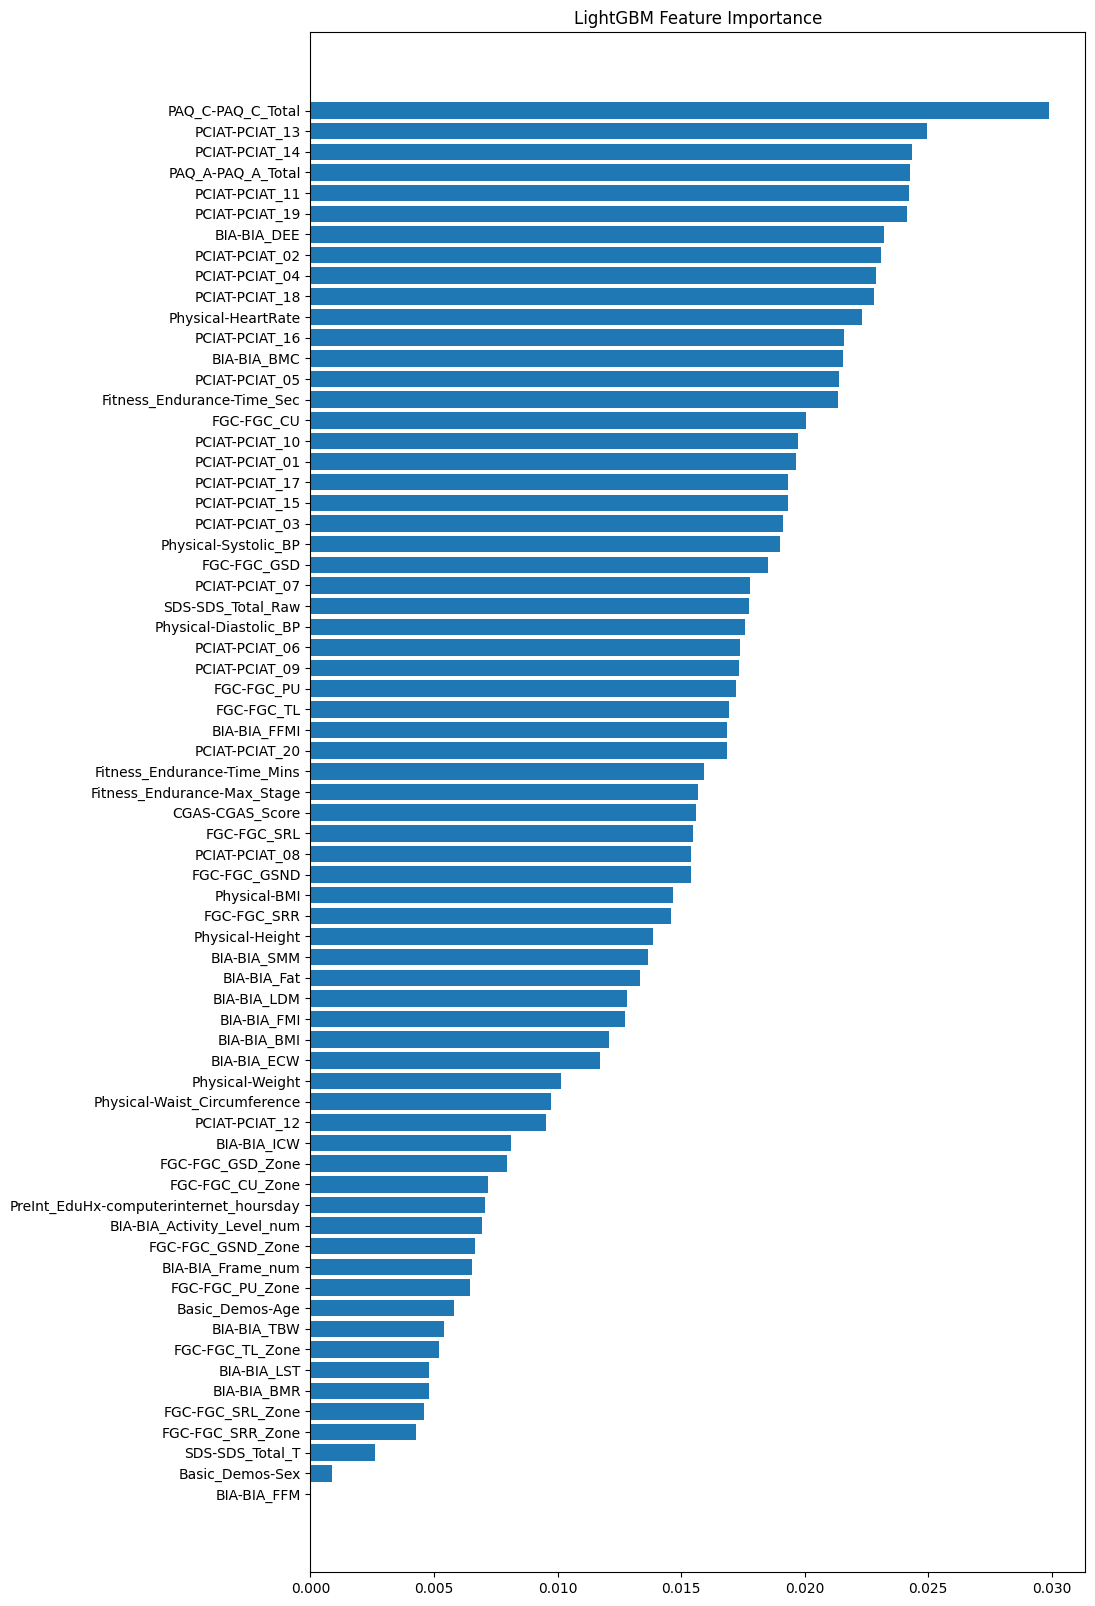

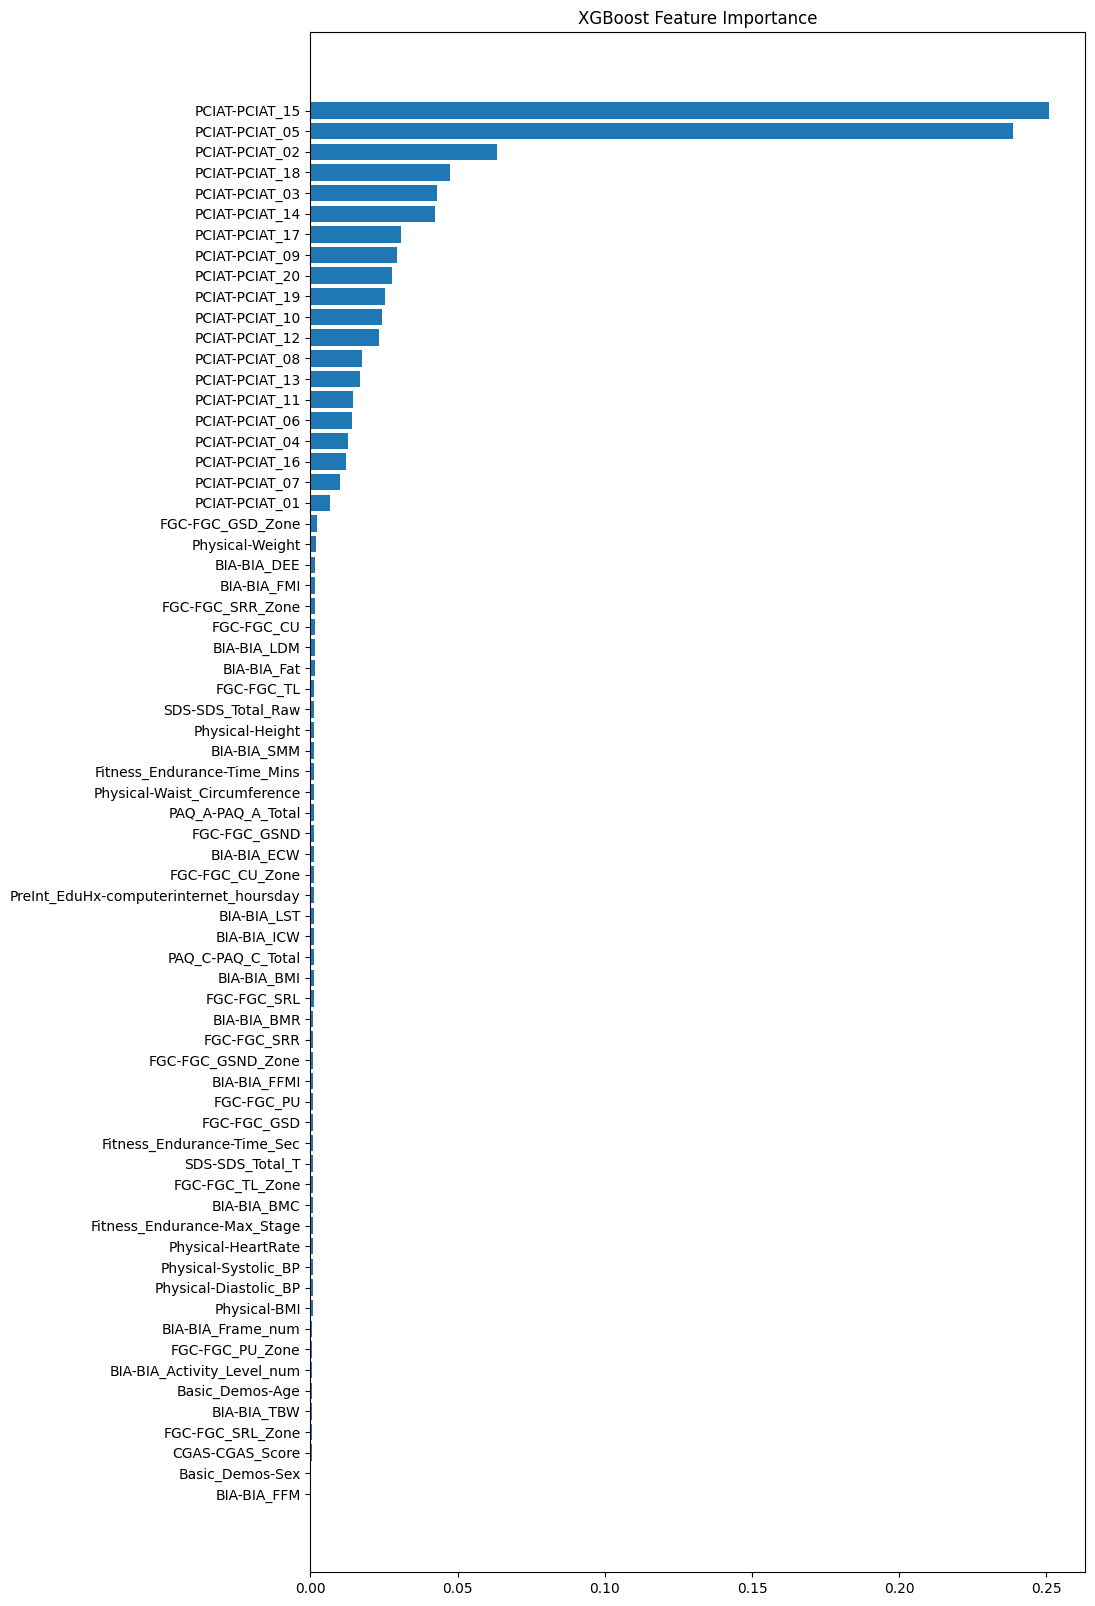

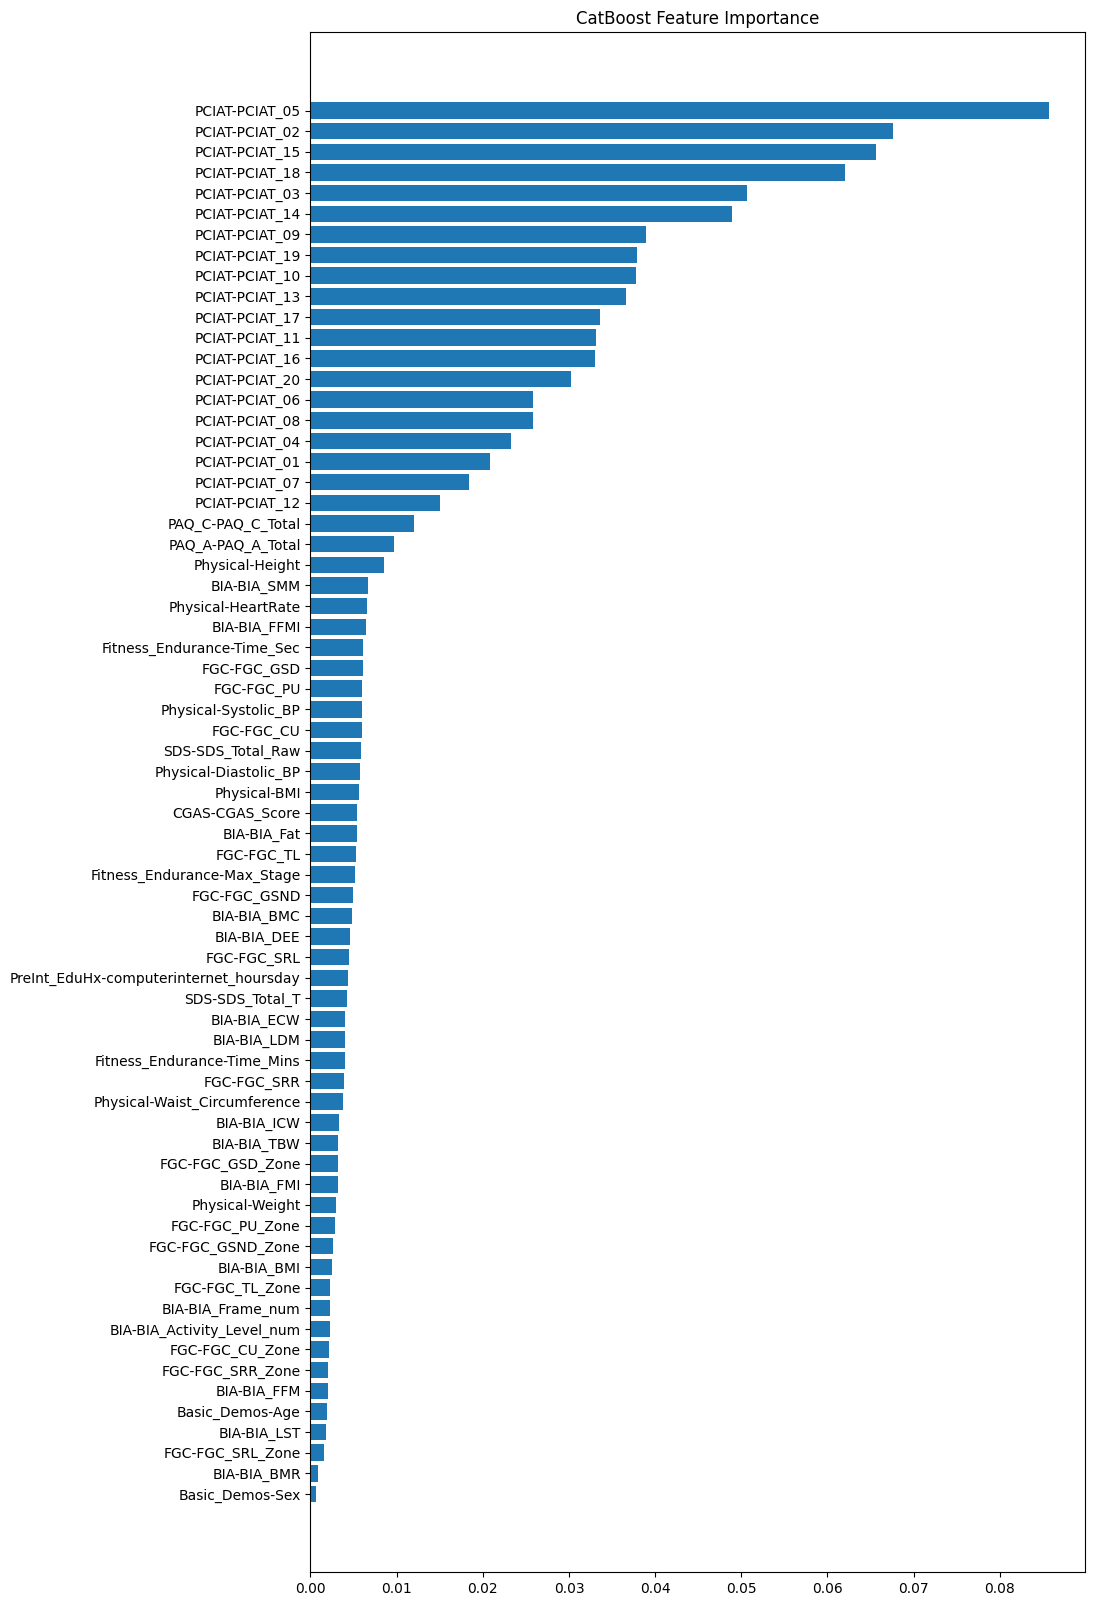

,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,0
3,00115b9f,1
4,0016bb22,1
5,001f3379,1
6,0038ba98,1
7,0068a485,0
8,0069fbed,1
9,0083e397,1


In [75]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.ensemble import VotingRegressor
import lightgbm as lgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from pytorch_tabnet.tab_model import TabNetRegressor

# Load your dataset


# Initialize individual models
lightgbm_model = lgb.LGBMRegressor()
xgboost_model = XGBRegressor()
catboost_model = CatBoostRegressor(silent=True)

# Wrap TabNet with the custom wrapper
tabnet_model = TabNetRegressorWrapper()

# Define the Voting Regressor
voting_model = VotingRegressor(estimators=[
    ('lightgbm', lightgbm_model),
    ('xgboost', xgboost_model),
    ('catboost', catboost_model),
    ('tabnet', tabnet_model)
])

Submission3 = TrainML(voting_model, test_data_with_predictions)

Submission3

In [76]:
# Submission.to_csv('submission.csv', index=False)

In [77]:
# Import necessary libraries
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import KNNImputer
import pandas as pd

# Load your dataset
df = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')

# Drop rows with missing values in 'sii'
df = df.dropna(subset=['sii'])

# Features (X): Drop target columns and irrelevant columns
irrelevant_columns = [
    'id', 'Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season',
    'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season',
    'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season', 'sii', 'PCIAT-Season',
    'PCIAT-PCIAT_Total'
]
X = df.drop(columns=irrelevant_columns)

# Convert all columns to numeric and handle invalid values
X = X.apply(pd.to_numeric, errors='coerce')

# Initialize the KNN Imputer
knn_imputer = KNNImputer(n_neighbors=71)

# Impute missing values and convert back to DataFrame
X_imputed = pd.DataFrame(knn_imputer.fit_transform(X), columns=X.columns)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, df["sii"], test_size=0.0001, random_state=42)

# Initialize the Gradient Boosting Classifier
model = GradientBoostingClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Get the feature importances
feature_importances = model.feature_importances_

# Ensure the test data has the same column order as the training data
test_data_with_predictions = test_data_with_predictions.reindex(columns=X_train.columns)

# Make predictions on the test data
y_pred = model.predict(test_data_with_predictions)

# Optionally, you can check the feature importance
print("Feature importance:")
for feature, importance in zip(X_train.columns, feature_importances):
    print(f"{feature}: {importance}")


Feature importance:
Basic_Demos-Age: 0.0005176879162060712
Basic_Demos-Sex: 0.0
CGAS-CGAS_Score: 0.0006685480126128085
Physical-BMI: 0.0020497620592288724
Physical-Height: 0.0009202360381224099
Physical-Weight: 0.0005168119091205531
Physical-Waist_Circumference: 0.0002620811994819522
Physical-Diastolic_BP: 0.002069778997582669
Physical-HeartRate: 0.0020076509875636985
Physical-Systolic_BP: 0.0008963858115415423
Fitness_Endurance-Max_Stage: 0.0006306723253286044
Fitness_Endurance-Time_Mins: 0.001073957160175097
Fitness_Endurance-Time_Sec: 0.0023737311189428686
FGC-FGC_CU: 0.0019635787712273386
FGC-FGC_CU_Zone: 0.00010839212016935582
FGC-FGC_GSND: 0.0008510777223301731
FGC-FGC_GSND_Zone: 0.0008235483196581186
FGC-FGC_GSD: 0.0019289487150968444
FGC-FGC_GSD_Zone: 0.001045054948383526
FGC-FGC_PU: 0.0010620112045921272
FGC-FGC_PU_Zone: 0.0001659818177074552
FGC-FGC_SRL: 0.0006323363515021313
FGC-FGC_SRL_Zone: 1.6730744829347554e-07
FGC-FGC_SRR: 0.0011083445084744594
FGC-FGC_SRR_Zone: 0.00012

In [78]:
y_pred

array([1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       0., 0., 1.])

In [79]:
sample = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv")
Submission123 = pd.DataFrame({
    'id': sample['id'],
    'sii': y_pred
})

In [81]:
sub1 = Submission1
sub2 = Submission123
sub3 = Submission3

sub1 = sub1.sort_values(by='id').reset_index(drop=True)
sub2 = sub2.sort_values(by='id').reset_index(drop=True)
sub3 = sub3.sort_values(by='id').reset_index(drop=True)

combined = pd.DataFrame({
    'id': sub1['id'],
    'sii_1': sub1['sii'],
    'sii_2': sub2['sii'],
    'sii_3': sub3['sii']
})

def majority_vote(row):
    return row.mode()[0]

combined['final_sii'] = combined[['sii_1', 'sii_2', 'sii_3']].apply(majority_vote, axis=1)

final_submission = combined[['id', 'final_sii']].rename(columns={'final_sii': 'sii'})

final_submission.to_csv('submission.csv', index=False)